In [1]:
import sys ; sys.path.append('..')

from src.control.utils import prior_dist, target_dist, dummy_trainloader, weighted_log_likelihood_loss
from src.control.models import ControlledSystem, AugmentedDynamics
from src.control.learners import EnergyShapingLearner

import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Learner

In [2]:
from numpy import pi as pi

# UNIFORM "prior" distribution of initial conditions x(0) 
prior = prior_dist(-2*pi, 2*pi, -2*pi, 2*pi, device)

# NORMAL target distribution for x(T)
target = target_dist([0, 0], [.001, .001], device)

##### Define Integral Cost Function

In [3]:
class ControlEffort(nn.Module):
    # control effort integral cost
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            q = x[:,:1].requires_grad_(True)
            u = self.f._energy_shaping(q) + self.f._damping_injection(x)
        return torch.abs(u)

##### Define NNs and model

In [4]:
# vector field parametrized by a NN
hdim = 64
V = nn.Sequential(
          nn.Linear(1, hdim),
          nn.Softplus(), 
          nn.Linear(hdim, hdim),
          nn.Tanh(), 
          nn.Linear(hdim, 1))
K = nn.Sequential(
          nn.Linear(2, hdim),
          nn.Softplus(),
          nn.Linear(hdim, 1),
          nn.Softplus())

for p in V[-1].parameters(): torch.nn.init.zeros_(p)
for p in K[-2].parameters(): torch.nn.init.zeros_(p)

f = ControlledSystem(V, K).to(device)
aug_f = AugmentedDynamics(f, ControlEffort(f))

t_span = torch.linspace(0, 3, 30)

### Train the Energy Shaping Controller

In [5]:
learn = EnergyShapingLearner(aug_f, prior, target, t_span)
learn.lr = 5e-3
logger = WandbLogger(project='optimal-energy-shaping', name='pend_adjoint')

trainer = pl.Trainer(max_epochs=3000, logger=logger, gpus=[0])
trainer.fit(learn)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: massastrello (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type              | Params
--------------------------------------------
0 | model | AugmentedDynamics | 4.6 K 
--------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
/home/stefano/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/stefano/anaconda3/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:237: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
/home/stefano/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Plot Results

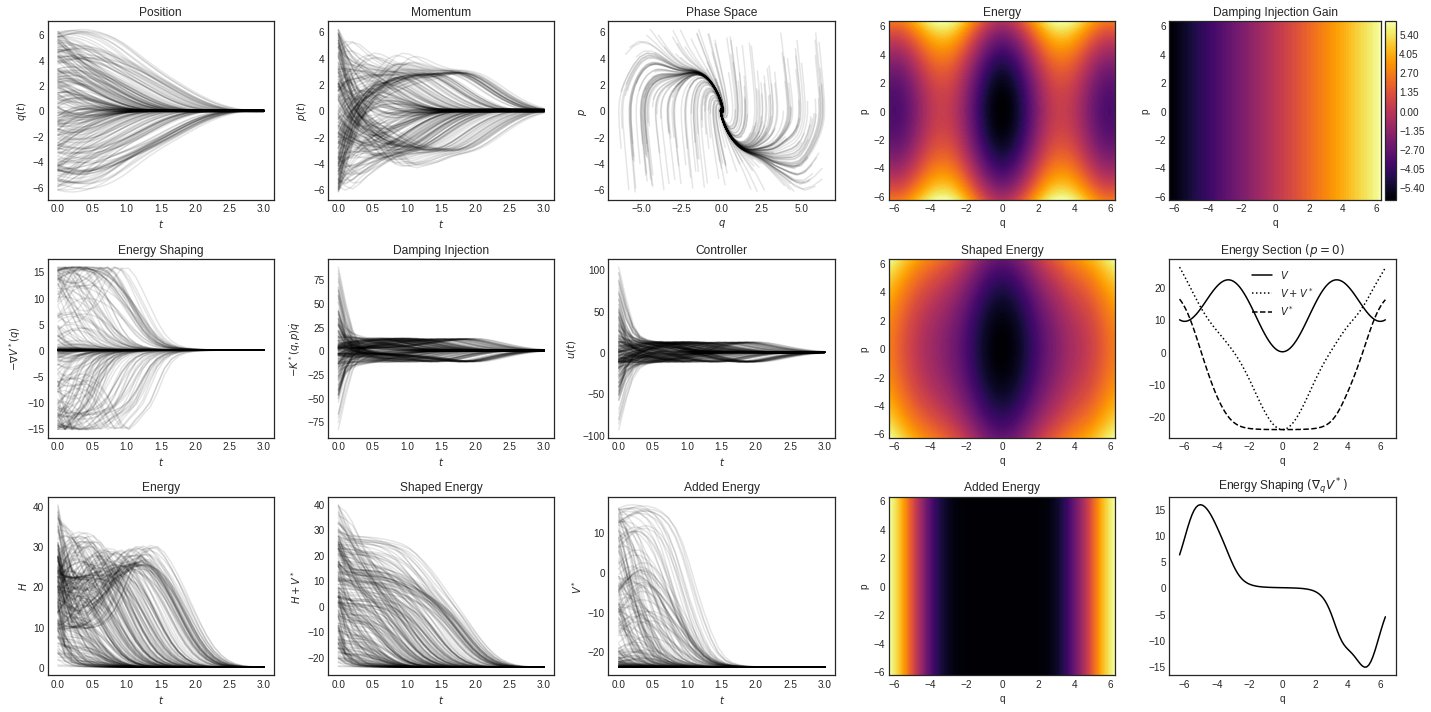

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchdiffeq import odeint

n_ic = 256
x0 = prior.sample(torch.Size([n_ic])).cpu()
x0 = torch.cat([x0, torch.zeros(n_ic, 1)], 1)
model = aug_f.cpu()
#
traj = odeint(model, x0, t_span, method='midpoint').detach()
traj = traj[..., :-1]
u_es = torch.cat([model.f._energy_shaping(q.requires_grad_()) for q in traj[:,:,:1]], 1).detach()
u_di = torch.cat([model.f._damping_injection(x) for x in traj], 1).detach()
u = (u_es + u_di)
H = torch.cat([model.f._autonomous_energy(x) for x in traj], 1).detach()
Hd = torch.cat([model.f._energy(x) for x in traj], 1).detach()
Ha = Hd - H
# plots on grid
n_grid = 100
q_grid, p_grid = torch.linspace(-2*pi, 2*pi, n_grid), torch.linspace(-2*pi, 2*pi, n_grid)
Q, P = torch.meshgrid(q_grid, p_grid) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], 1)
H_grid = model.f._autonomous_energy(z).reshape(n_grid, n_grid).detach()
Hd_grid = model.f._energy(z).reshape(n_grid, n_grid).detach()
Ha_grid = Hd_grid - H_grid
Kd_grid = Q #-model.defunc.m.f._damping_injection(z).reshape(n_grid, n_grid).detach()/P   
#
V_sec = model.f._autonomous_energy(torch.cat([q_grid[:,None], torch.zeros(n_grid,1)],1)).detach()
Vd_sec = model.f._energy(torch.cat([q_grid[:,None], torch.zeros(n_grid,1)],1)).detach()
Va_sec = Vd_sec - V_sec
u_es_sec = model.f._energy_shaping(q_grid[:, None].requires_grad_()).detach()
#
#model = model.to(device)
############

# plot
plt.style.use('seaborn-white')
fig, ax = plt.subplots(3, 5, figsize=(20,10))
##
ax[0,0].set_xlabel(r"$t$") ; ax[0,1].set_xlabel(r"$t$") ; ax[0,2].set_xlabel(r"$q$")
ax[0,0].set_ylabel(r"$q(t)$") ; ax[0,1].set_ylabel(r"$p(t)$") ; ax[0,2].set_ylabel(r"$p$")
ax[1,0].set_xlabel(r"$t$") ; ax[1,1].set_xlabel(r"$t$") ; ax[1,2].set_xlabel(r"$t$")
ax[1,0].set_ylabel(r"$-\nabla V^*(q)$") ; ax[1,1].set_ylabel(r"$-K^*(q,p)\dot q$") ; ax[1,2].set_ylabel(r"$u(t)$")
ax[2,0].set_xlabel(r"$t$") ; ax[2,1].set_xlabel(r"$t$") ; ax[2,2].set_xlabel(r"$t$")
ax[2,0].set_ylabel(r"$H$") ; ax[2,1].set_ylabel(r"$H + V^*$") ; ax[2,2].set_ylabel(r"$V^*$")
ax[0,0].set_title("Position") ; ax[0,1].set_title("Momentum") ; ax[0,2].set_title("Phase Space") 
ax[1,0].set_title("Energy Shaping") ; ax[1,1].set_title("Damping Injection") ; ax[1,2].set_title("Controller") 
ax[2,0].set_title("Energy") ; ax[2,1].set_title("Shaped Energy") ; ax[2,2].set_title("Added Energy") 
for i in range(n_ic):
    ax[0,0].plot(t_span, traj[:,i,0], 'k', alpha=.1)
    ax[0,1].plot(t_span, traj[:,i,1], 'k', alpha=.1)
    ax[0,2].plot(traj[:,i,0], traj[:,i,1], 'k', alpha=.1)
    ax[1,0].plot(t_span, u_es[i,:], 'k', alpha=.1)
    ax[1,1].plot(t_span, u_di[i,:], 'k', alpha=.1)
    ax[1,2].plot(t_span, u[i,:], 'k', alpha=.1)
    ax[2,0].plot(t_span, H[i,:], 'k', alpha=.1)
    ax[2,1].plot(t_span, Hd[i,:], 'k', alpha=.1)
    ax[2,2].plot(t_span, Ha[i,:], 'k', alpha=.1)
##
ax[0,3].set_xlabel("q") ; ax[1,3].set_xlabel("q") ; ax[2,3].set_xlabel("q") ; ax[0,4].set_xlabel("q")
ax[0,3].set_ylabel("p") ; ax[1,3].set_ylabel("p") ; ax[2,3].set_ylabel("p") ; ax[0,4].set_ylabel("p")
ax[0,3].set_title("Energy") ; ax[1,3].set_title("Shaped Energy") ; ax[2,3].set_title("Added Energy") ; ax[0,4].set_title("Damping Injection Gain") 
ax[0,3].contourf(Q, P, H_grid, 100, cmap='inferno')
ax[1,3].contourf(Q, P, Hd_grid, 100, cmap='inferno')
ax[2,3].contourf(Q, P, Ha_grid, 100, cmap='inferno')
plot = ax[0,4].contourf(Q, P, Kd_grid, 100, cmap='inferno') ; divider = make_axes_locatable(ax[0,4])
cax = divider.append_axes("right", size="5%", pad=0.05) ; plt.colorbar(plot, cax=cax)
##
ax[1,4].set_title(r"Energy Section $(p=0)$") ; ax[1,4].set_xlabel("q")
ax[1,4].plot(q_grid, V_sec, 'k') ; ax[1,4].plot(q_grid, Vd_sec, ':k') ; ax[1,4].plot(q_grid, Va_sec, '--k')
ax[1,4].legend(['$V$', r"$V+V^*$", "$V^*$"])
##
ax[2,4].set_title(r"Energy Shaping $(\nabla_q V^*)$") ; ax[2,4].set_xlabel("q")
ax[2,4].plot(q_grid, u_es_sec, 'k')
fig.tight_layout()

#plt.savefig('tmp/test.png', dpi=300)